# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [Antonin Morel]([link](https://github.com/Cbonvieuxziz))
- [Benjamin Renoux]([link](https://github.com/Ben1306))

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import matplotlib.pyplot as plt

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

Number training samples :  100
Number test samples :  200


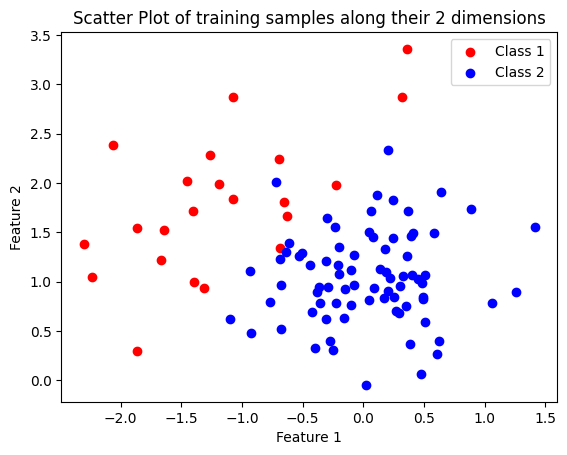

In [19]:
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
print("Number training samples : ", N_train)

# load the test set
test = np.loadtxt('data/synth_test.txt') 
class_test = test[:,0]
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
print("Number test samples : ", N_test)

condition = class_train == 1
plt.scatter(x_train[condition,0], x_train[condition,1], c='r', label='Class 1')
plt.scatter(x_train[~condition,0], x_train[~condition,1], c='b', label='Class 2')
plt.title('Scatter Plot of training samples along their 2 dimensions')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


**Answer:**

In [20]:
# Returns the distance of a point x to every point of mat
def distances(x, mat):
    N = np.shape(mat)[0]
    extended_x = np.array([x for k in range(N)])
    return np.linalg.norm( extended_x - mat, axis=1)

# Implementation of K Nearest Neighors algorithm
# Works for classification as well as regression
def K_Nearest(K, mode, x_test, x_train, y_train):
    N = np.shape(x_test)[0]
    # We compute the distances to each point of the training set
    x_test_distances = np.array([distances(x, x_train) for x in x_test])    
    #Sort the distances
    id = np.argsort(x_test_distances)[:,:K]
    labels = y_train[id].astype(int)
    inferred = np.array([])
    if mode == "classification":
        inferred = np.array( [np.argmax(np.bincount(labels[k,:])) for k in range (N)] )
    elif mode == "regression":
        inferred = np.array( [np.mean(labels[k,:]) for k in range (N)] )
    assert len(inferred) > 0, "Mode must be 'classification' or 'regression'"
    return inferred

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

Best K value is  2  with  9  errors.
This represents  95.5 % of precision


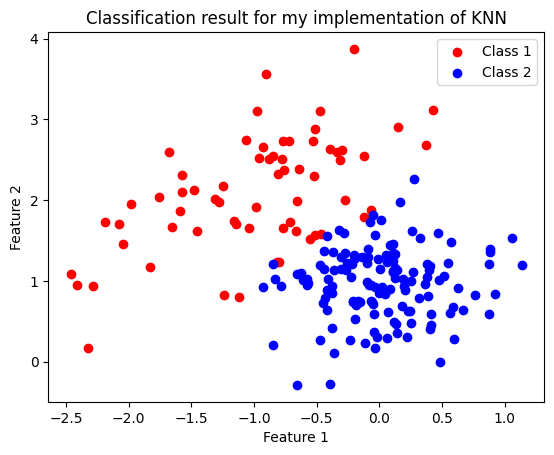

In [21]:
def compute_error(K_max, show_result=True):
    true_class_of_test_set = class_test
    errors_on_test_set = np.array([0 for k in range(K_max)])
    for k in range(1, K_max + 1):
        inferred_classes_for_test_set =  K_Nearest(k, "classification", x_test, x_train,class_train)
        error_test = np.sum(inferred_classes_for_test_set != true_class_of_test_set)
        errors_on_test_set[k-1] = error_test

    # We get the K with lowest error
    best_K = np.argmin(errors_on_test_set)
    lowest_error = np.min(errors_on_test_set)
    N = np.shape(x_test)[0]
    if show_result:
        print("Best K value is ", best_K, " with ", lowest_error, " errors.")
        print("This represents ", 100 - (lowest_error/N)*100 ,"% of precision")
        inferred_classes = K_Nearest(best_K, "classification", x_test, x_train,class_train)
        condition = inferred_classes == 1
        colors = np.where(condition, 'r', 'b')
        plt.scatter(x_test[condition,0], x_test[condition,1], c='r', label='Class 1')
        plt.scatter(x_test[~condition,0], x_test[~condition,1], c='b', label='Class 2')
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.title("Classification result for my implementation of KNN")
        plt.legend()
        plt.show()

compute_error(20)

4\. Comment on your results. Which value of $K$ seems optimal ?


Giving our result, it seems that a value of K = 2 is optimal. By looking at the graphic, the result seems indeed to feat the shape of the training dataset.

**Answer:**

We only have a restraigned set of training points so our model can't be really accurate.
However it performs a 95% of precision on the testing set which seems a good result.
Giving the training dataset that we have, K=2 seems optimal

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

Best K value is  2  with  9  errors.
This represents  95.5 % of precision


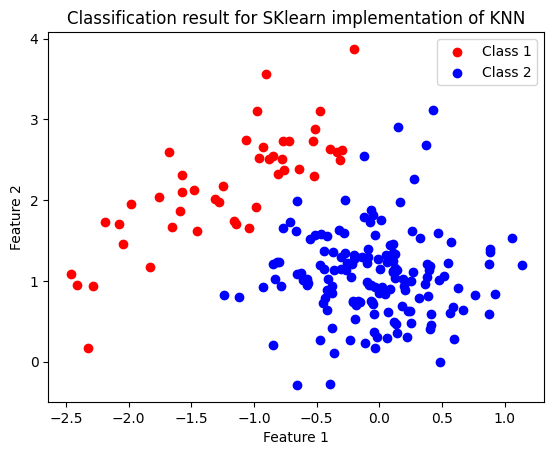

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def sklearn_knclassifier(k,x_train,class_train, x_test, class_test):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(x_train, class_train)

    class_pred = knn_classifier.predict(x_test)
    #accuracy = accuracy_score(class_test, class_pred)
    #print(f'Accuracy: {accuracy:.2f}%')
    return class_pred


def compute_error_sklearn(K_max,show_result=True):
    true_class_of_test_set = class_test
    errors_on_test_set = np.array([0 for k in range(K_max)])
    for k in range(1, K_max + 1):
        inferred_classes_for_test_set = sklearn_knclassifier(k,x_train,class_train, x_test, class_test)
        error_test = np.sum(inferred_classes_for_test_set != true_class_of_test_set)
        errors_on_test_set[k-1] = error_test

    # We get the K with lowest error
    best_K = np.argmin(errors_on_test_set)
    lowest_error = np.min(errors_on_test_set)
    N = np.shape(x_test)[0]
    if show_result:
        print("Best K value is ", best_K, " with ", lowest_error, " errors.")
        print("This represents ", 100 - (lowest_error/N)*100 ,"% of precision")
        inferred_classes = sklearn_knclassifier(k,x_train,class_train, x_test, class_test)
        condition = inferred_classes == 1
        colors = np.where(condition, 'r', 'b')
        plt.scatter(x_test[condition,0], x_test[condition,1], c='r', label='Class 1')
        plt.scatter(x_test[~condition,0], x_test[~condition,1], c='b', label='Class 2')
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.title("Classification result for SKlearn implementation of KNN")
        plt.legend()
        plt.show()

compute_error_sklearn(20)

In [23]:
# Let's time our 2 versions of the algorithm
import timeit


my_version_time =  timeit.timeit(
    lambda: K_Nearest(2, "classification", x_test, x_train, class_train),
    number=100
)

sklearn_version_time = timeit.timeit(
    lambda: sklearn_knclassifier(2,x_train,class_train, x_test, class_test),
    number=100
)

print("Time to execute my implementation : ", my_version_time)
print("Time to execute sklearn implementation : ", sklearn_version_time)
print(f'The relative speed of sklearn compared to our implementation is {100-round((sklearn_version_time/my_version_time)*100,2)}%')

Time to execute my implementation :  1.3088982900080737
Time to execute sklearn implementation :  1.228989498980809
The relative speed of sklearn compared to our implementation is 6.109999999999999%


### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

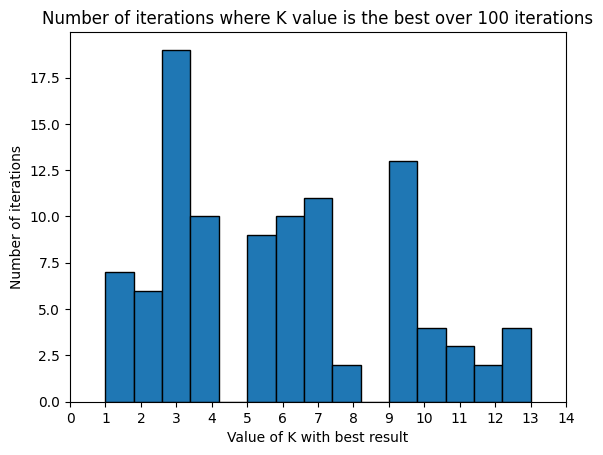

In [24]:
# your code
from sklearn.model_selection import train_test_split

train = np.loadtxt('data/wdbc12.data.txt', delimiter=',')
train.shape

X = train[:,2:]
y = train[:,1]

k_max = 15
best_k_over_splits = []
number_of_loops = 100
for _ in range(number_of_loops):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    best_k = 0
    best_accuracy = 0

    for k in range(1,k_max):
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(X_train, y_train)
        class_pred = knn_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, class_pred)
        #print(f'For K = {k}, accuracy: {accuracy:.5f}%')
        if accuracy>best_accuracy:
            best_accuracy = accuracy
            best_k = k
    best_k_over_splits.append(best_k)
    #print(f'Best accuracy obtained was {best_accuracy:.5f}% for K = {best_k}')

plt.hist(best_k_over_splits,bins=k_max, edgecolor="k")
plt.xticks(range(k_max))
plt.title("Number of iterations where K value is the best over 100 iterations")
plt.xlabel("Value of K with best result")
plt.ylabel("Number of iterations")
plt.show()


We observe that our value of optimal K is very volatile (it changes whenever we change the training and test sets). We then decided to find the best value of K for different training sets and we plotted the density of the best K we obtained.
It seems that in the most cases, our best value for K is between 3 & 5.

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [25]:
!cd example_cy && python3 setup.py build_ext --inplace

running build_ext


In [26]:
import example_cy.example_cy.helloworld as toy

toy.printhello()

Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [27]:
import example_np_cy.compute_cy as toy

mat1 = np.array([[13,14]], dtype=np.intc)
mat2 = np.array([[7,13]], dtype=np.intc)
toy.compute(mat1, mat2, 4, 5, 8)

array([[ 83, 113]], dtype=int32)

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [28]:
!cd knn_cy && python3 setup.py build_ext --inplace

Compiling knn_cython.pyx because it depends on /Users/benji/Documents/G3/Cours/Python/git_anto/python_sdia/venv/lib/python3.10/site-packages/numpy/__init__.cython-30.pxd.
[1/1] Cythonizing knn_cython.pyx
running build_ext
building 'knn_cython' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -arch x86_64 -g -I/Users/benji/Documents/G3/Cours/Python/git_anto/python_sdia/venv/lib/python3.10/site-packages/numpy/core/include -I/Users/benji/Documents/G3/Cours/Python/git_anto/python_sdia/venv/include -I/Library/Frameworks/Python.framework/Versions/3.10/include/python3.10 -c knn_cython.c -o build/temp.macosx-10.9-universal2-cpython-310/knn_cython.o
In file included from knn_cython.c:1176:
In file included from /Users/benji/Documents/G3/Cours/Python/git_anto/python_sdia/venv/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/benji/Documents/G3/Cours/Python/git_anto/python_sdia/v

In [35]:
import numpy as np
import knn_cy.knn_cy.knn_cython as knn # Import the Cython module

# Create some sample data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
K = 2
mode = "classification"

# Call the Cython K_Nearest function
result = knn.K_Nearest(K, mode, X_test, X_train, y_train)

Our Cython implementation of Knn is working as everything is compiling without throwing any error.

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [30]:
# Let's time our 2 versions of the algorithm
import timeit


my_version_time =  timeit.timeit(
    lambda: K_Nearest(K, mode, X_test, X_train, y_train),
    number=100
)

cython_version_time = timeit.timeit(
    lambda: knn.K_Nearest(K, mode, X_test, X_train, y_train),
    number=100
)

print("Time to execute my implementation : ", my_version_time)
print("Time to execute Cython implementation : ", cython_version_time)
print(f'The relative speed of Cython compared to our Python implementation is {100-round((cython_version_time/my_version_time)*100,2)}%')

Time to execute my implementation :  3.3075891429907642
Time to execute Cython implementation :  3.053651181020541
The relative speed of Cython compared to our Python implementation is 7.680000000000007%


The lack of improvement maybe comes from the fact that we use in our Python implementation lots of numpy built-in functions which already are optimised and efficients.

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

### We re-import our function of gradient and Total Variation from Lab 2

In [31]:
# your code
def gradient2D(X):
    """
    Compute the 2D discrete gradient operator applied to a matrix X.

    Parameters:
    X (ndarray): Input 2D array of shape (M, N).

    Returns: (D_x,D_y)
    D_x (ndarray): Gradient in the x-direction of shape (M, N).
    D_y (ndarray): Gradient in the y-direction of shape (M, N).

    Raises:
    AssertionError: If the input array X has more than 2 dimensions.

    The 2D discrete gradient operator computes the gradients in the x and y
    directions of a 2D matrix. It uses finite differences to calculate the
    differences between neighboring elements along the horizontal and vertical
    directions.

    Example:
    >>> square_matrix = np.array( [[1,1,1],[2,2,2],[3,3,3]])
    >>> gradient = gradient2D(square_matrix)
    """
    assert X.ndim == 2
    M = np.shape(X)[0]
    N = np.shape(X)[1]
    XD_h = np.concatenate( [np.diff(X, axis=1), np.zeros((M,1))], axis=1 )
    D_vX = np.concatenate( [np.diff(X, axis=0), np.zeros((1,N))], axis=0 )
    return(XD_h, D_vX)


def tv(X):
    """
    Compute the Total Variation (TV) of a 2D complex-valued matrix X.

    Parameters:
    X (ndarray): Input 2D complex-valued array of shape (M, N).

    Returns:
    tv_value (float): Total Variation of the input matrix X.

    The Total Variation (TV) of a 2D matrix X is a measure of the variation or
    "complexity" of the matrix.
    
    """
    M = np.shape(X)[0]
    N = np.shape(X)[1]
    grad = gradient2D(X)

    tv_value = 0

    for m in range(M):
        for n in range(N):
            tv_value+= np.sqrt( grad[0][m,n]**2 + grad[1][m,n]**2 )
    return tv_value

### We convert them in Numba synthax

In [32]:
import numpy as np
from numba import jit

@jit(nopython=True)
def numba_gradient2D(X):
    assert X.ndim == 2
    M, N = X.shape
    XD_h = np.empty((M, N), dtype=np.int32)  # Specify integer data type
    D_vX = np.empty((M, N), dtype=np.int32)  # Specify integer data type

    for m in range(M):
        for n in range(N - 1):
            XD_h[m, n] = X[m, n + 1] - X[m, n]
        XD_h[m, N - 1] = 0

    for m in range(M - 1):
        for n in range(N):
            D_vX[m, n] = X[m + 1, n] - X[m, n]
    return XD_h, D_vX

@jit(nopython=True)
def numba_tv(X):
    M, N = X.shape
    grad = numba_gradient2D(X)

    tv_value = 0

    for m in range(M):
        for n in range(N):
            tv_value += np.sqrt(grad[0][m, n] ** 2 + grad[1][m, n] ** 2)
    return tv_value

2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [33]:
import timeit

M = 1000  # Number of rows
N = 1000  # Number of columns
big_matrix = np.random.rand(M, N)


numba_tv(big_matrix)

my_version_time =  timeit.timeit(
    lambda: tv(big_matrix),
    number=10
)

numba_version_time =  timeit.timeit(
    lambda: numba_tv(big_matrix),
    number=10
)

print("Time to execute our implementation : ", my_version_time)
print("Time to execute Numba implementation : ", numba_version_time)


Time to execute our implementation :  17.78783129801741
Time to execute Numba implementation :  0.04738833999726921


It is clear that Numba greatly accelerates the processing of the TV algorithm. Its structure of intricated for loops perfectly suits the Numba logic and allows a great improvement.